In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import GRU, LSTM, Dropout, Dense
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

/Users/maushariff/Downloads/Local_Disk_E/Byrav/Fall24 996 Reserach with Internet2 Data/VsCodeWorkspace/myenv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Load the combined parquet data

file_path = '/Users/maushariff/Downloads/Local_Disk_E/Byrav/Internet2_Data/Data/combined_router_dallas_atla_data.parquet'
df = pd.read_parquet(file_path)


In [3]:
# Convert 't_first' to datetime and set it as the index for resampling
df['t_first'] = pd.to_datetime(df['t_first'])

In [4]:
# Separate the Atlanta and Dallas data
atlanta_data = df[df['router'] == 'Atlanta'].resample('H', on='t_first')['in_packets'].sum().reset_index()
dallas_data = df[df['router'] == 'Dallas'].resample('H', on='t_first')['in_packets'].sum().reset_index()

# Rename columns for consistency
atlanta_data.columns = ['ds', 'y']
dallas_data.columns = ['ds', 'y']

/var/folders/l_/89dqsbtj1ys_lqvc8b_phr300000gq/T/ipykernel_80021/1708584142.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  atlanta_data = df[df['router'] == 'Atlanta'].resample('H', on='t_first')['in_packets'].sum().reset_index()
/var/folders/l_/89dqsbtj1ys_lqvc8b_phr300000gq/T/ipykernel_80021/1708584142.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dallas_data = df[df['router'] == 'Dallas'].resample('H', on='t_first')['in_packets'].sum().reset_index()


In [5]:
# Concatenate both datasets
combined_data = pd.concat([atlanta_data, dallas_data])

In [6]:
# Scale the data (you can scale separately for each router if needed)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(combined_data[['y']])


In [7]:
# Modify the function to create sequences for multi-step forecasting
def create_sequences(data, seq_length, n_steps_out):
    xs, ys = [], []
    for i in range(len(data) - seq_length - n_steps_out + 1):
        x = data[i:i + seq_length]
        y = data[i + seq_length:i + seq_length + n_steps_out]  # Predict multiple steps ahead
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define sequence length and number of steps to predict
sequence_length = 24  # Input sequence length (e.g., 24 hours)
n_steps_out = 2  # Change to 2, 5, or 10 for different multi-step forecasting

# Create sequences for multi-step LSTM-GRU
X, y = create_sequences(scaled_data, sequence_length, n_steps_out)

In [8]:
# Reshape X for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets (80% train, 20% test)
train_size = int(0.8 * X.shape[0])
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [9]:
# Define the LSTM-GRU model
model = Sequential()
model.add(GRU(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
# model.add(Dense(1)) #this line was for 1 step
model.add(Dense(n_steps_out))  # Output layer predicts 'n_steps_out' steps

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])


/Users/maushariff/Downloads/Local_Disk_E/Byrav/Fall24 996 Reserach with Internet2 Data/VsCodeWorkspace/myenv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# Define model checkpoint
checkpoint = ModelCheckpoint("weights.best.keras", monitor='val_mse', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [11]:
# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=8, verbose=1, validation_data=(X_val, y_val), callbacks=callbacks_list)


Epoch 1/200
120/122 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0225 - mae: 0.0878 - mse: 0.0225
Epoch 1: val_mse improved from inf to 0.00908, saving model to weights.best.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0222 - mae: 0.0874 - mse: 0.0222 - val_loss: 0.0091 - val_mae: 0.0585 - val_mse: 0.0091
Epoch 2/200
120/122 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0066 - mae: 0.0523 - mse: 0.0066
Epoch 2: val_mse improved from 0.00908 to 0.00591, saving model to weights.best.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0066 - mae: 0.0523 - mse: 0.0066 - val_loss: 0.0059 - val_mae: 0.0453 - val_mse: 0.0059
Epoch 3/200
120/122 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0064 - mae: 0.0501 - mse: 0.0064
Epoch 3: val_mse improved from 0.00591 to 0.00443, saving model to weights.best.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0064 - mae: 0.0500 - mse: 0.0064 - val_loss: 0.0044 - val_mae: 0.0411 - val_mse: 0.0044
Epoch 4/200
121/122 ━━━━━━━━━━━━━━━

In [12]:
# Make predictions
predictions = model.predict(X_test)

# Inverse transform predictions and actual data
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


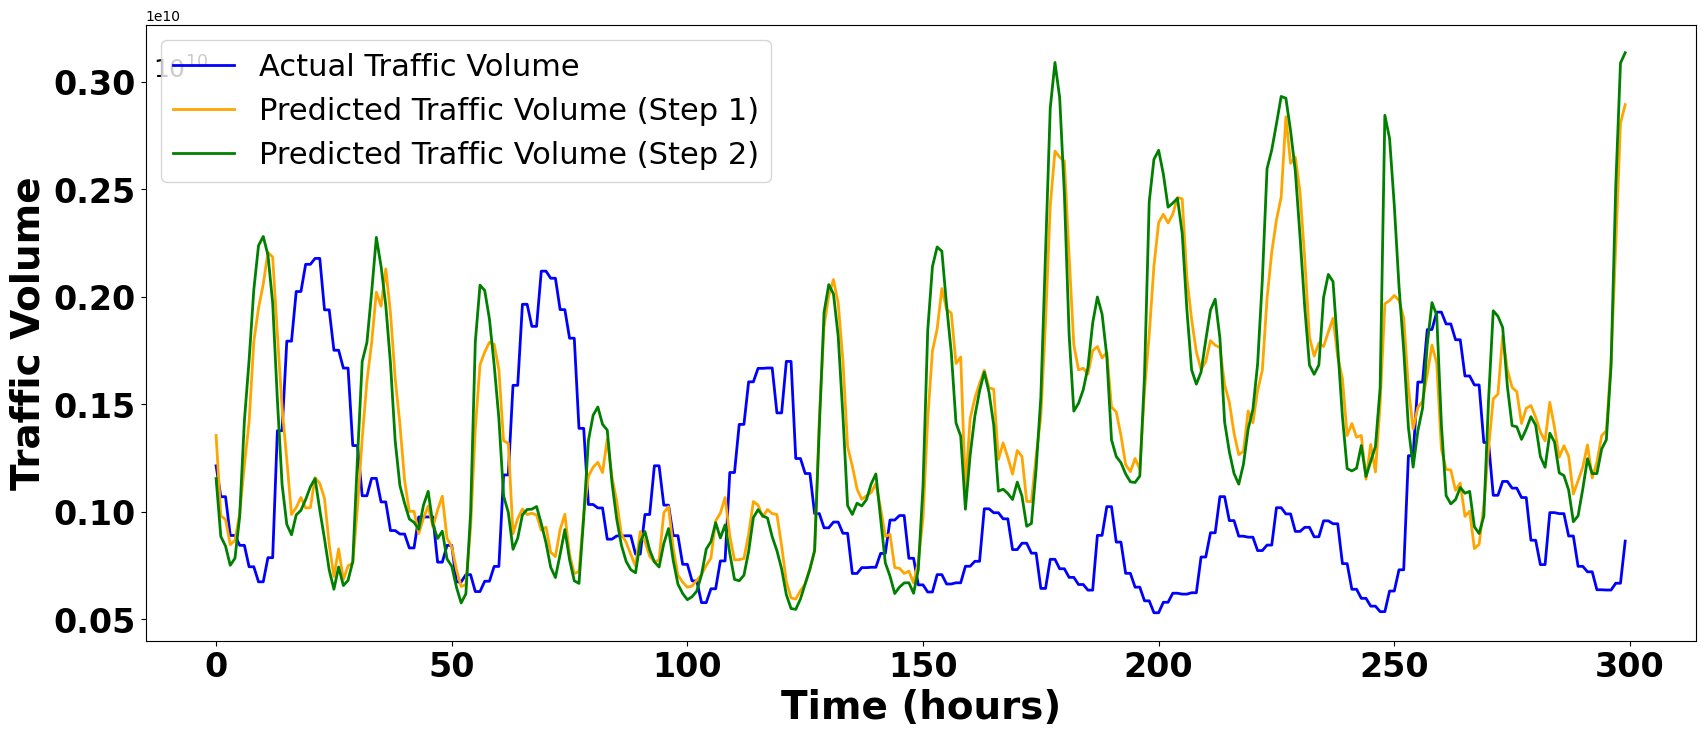

In [21]:
import matplotlib.pyplot as plt

# Select only the first 300 hours of the actual and predicted data
hours_limit = 300
y_test_rescaled_300 = y_test_rescaled[:hours_limit]
predictions_rescaled_step1_300 = predictions_rescaled_step1[:hours_limit]
predictions_rescaled_step2_300 = predictions_rescaled_step2[:hours_limit]

# Plot the results
plt.figure(figsize=(20, 8))
plt.plot(y_test_rescaled_300, label='Actual Traffic Volume', linewidth=2, color='blue')
plt.plot(predictions_rescaled_step1_300, label='Predicted Traffic Volume (Step 1)', linewidth=2, color='orange')
plt.plot(predictions_rescaled_step2_300, label='Predicted Traffic Volume (Step 2)', linewidth=2, color='green')

# Adjust font size for labels and legend
plt.xlabel('Time (hours)', fontsize=28, fontweight='bold')
plt.ylabel('Traffic Volume', fontsize=28, fontweight='bold')
plt.legend(fontsize=22)

# Suppress scientific notation at the top and add custom label
plt.ticklabel_format(style='sci', axis='y', scilimits=(10, 10), useOffset=False)
plt.annotate(r'$10^{10}$', xy=(0.005, 0.95), xycoords='axes fraction', fontsize=18,
             verticalalignment='top', fontweight='bold')

# Increase font size for tick labels on x and y axes and bold them
plt.xticks(fontsize=24, fontweight='bold')
plt.yticks(fontsize=24, fontweight='bold')

# Show the plot
plt.show()


In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import GRU, LSTM, Dropout, Dense
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Function to create sequences for multi-step forecasting
def create_sequences(data, seq_length, n_steps_out):
    xs, ys = [], []
    for i in range(len(data) - seq_length - n_steps_out + 1):
        x = data[i:i + seq_length]
        y = data[i + seq_length:i + seq_length + n_steps_out]  # Predict 'n_steps_out' steps ahead
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Update sequence length and prediction steps
sequence_length = 24  # Using 24 previous hours as input
n_steps_out_5 = 5  # For 5-step prediction
n_steps_out_10 = 10  # For 10-step prediction

# Create sequences for 5-step and 10-step forecasting
X_5, y_5 = create_sequences(scaled_data, sequence_length, n_steps_out_5)
X_10, y_10 = create_sequences(scaled_data, sequence_length, n_steps_out_10)

# Reshape X for LSTM (both 5-step and 10-step)
X_5 = X_5.reshape((X_5.shape[0], X_5.shape[1], 1))
X_10 = X_10.reshape((X_10.shape[0], X_10.shape[1], 1))

# Split data into training and testing sets
train_size_5 = int(0.8 * X_5.shape[0])
X_train_5, X_test_5 = X_5[:train_size_5], X_5[train_size_5:]
y_train_5, y_test_5 = y_5[:train_size_5], y_5[train_size_5:]

train_size_10 = int(0.8 * X_10.shape[0])
X_train_10, X_test_10 = X_10[:train_size_10], X_10[train_size_10:]
y_train_10, y_test_10 = y_10[:train_size_10], y_10[train_size_10:]

# Define and compile the LSTM-GRU model (same for both 5-step and 10-step)
def build_model(input_shape, n_steps_out):
    model = Sequential()
    model.add(GRU(64, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.25))
    model.add(LSTM(256))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(n_steps_out))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
    return model


In [28]:
# Train for 5-step prediction
model_5 = build_model((X_train_5.shape[1], X_train_5.shape[2]), n_steps_out_5)
model_5.fit(X_train_5, y_train_5, epochs=200, batch_size=8, verbose=1, validation_data=(X_test_5, y_test_5))



Epoch 1/200


/Users/maushariff/Downloads/Local_Disk_E/Byrav/Fall24 996 Reserach with Internet2 Data/VsCodeWorkspace/myenv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0237 - mae: 0.0933 - mse: 0.0237 - val_loss: 0.0028 - val_mae: 0.0437 - val_mse: 0.0028
Epoch 2/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0103 - mae: 0.0643 - mse: 0.0103 - val_loss: 0.0024 - val_mae: 0.0396 - val_mse: 0.0024
Epoch 3/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0084 - mae: 0.0560 - mse: 0.0084 - val_loss: 0.0027 - val_mae: 0.0403 - val_mse: 0.0027
Epoch 4/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0100 - mae: 0.0596 - mse: 0.0100 - val_loss: 0.0025 - val_mae: 0.0380 - val_mse: 0.0025
Epoch 5/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0065 - mae: 0.0495 - mse: 0.0065 - val_loss: 0.0048 - val_mae: 0.0606 - val_mse: 0.0048
Epoch 6/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0094 - mae: 0.0587 - mse: 0.0094 - val_loss: 0.0022 - val_mae: 0.0363 - val_mse: 0.0022
Epoch 7/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0093 - mae: 0.0578 - mse: 0.0093 - v

In [29]:


# Train for 10-step prediction
model_10 = build_model((X_train_10.shape[1], X_train_10.shape[2]), n_steps_out_10)
model_10.fit(X_train_10, y_train_10, epochs=200, batch_size=8, verbose=1, validation_data=(X_test_10, y_test_10))

Epoch 1/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0202 - mae: 0.0876 - mse: 0.0202 - val_loss: 0.0043 - val_mae: 0.0574 - val_mse: 0.0043
Epoch 2/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0144 - mae: 0.0752 - mse: 0.0144 - val_loss: 0.0028 - val_mae: 0.0390 - val_mse: 0.0028
Epoch 3/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0114 - mae: 0.0655 - mse: 0.0114 - val_loss: 0.0024 - val_mae: 0.0386 - val_mse: 0.0024
Epoch 4/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0119 - mae: 0.0673 - mse: 0.0119 - val_loss: 0.0025 - val_mae: 0.0375 - val_mse: 0.0025
Epoch 5/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0096 - mae: 0.0622 - mse: 0.0096 - val_loss: 0.0032 - val_mae: 0.0472 - val_mse: 0.0032
Epoch 6/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0110 - mae: 0.0646 - mse: 0.0110 - val_loss: 0.0027 - val_mae: 0.0388 - val_mse: 0.0027
Epoch 7/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0106 - mae: 0.0622 - mse

In [40]:
# Evaluate for 5-step prediction
predictions_5 = model_5.predict(X_test_5)

# Reshape predictions and actual test data to 2D for inverse transformation
predictions_rescaled_5 = scaler.inverse_transform(predictions_5.reshape(-1, 1))
y_test_rescaled_5 = scaler.inverse_transform(y_test_5.reshape(-1, 1))

# Evaluate for 10-step prediction
predictions_10 = model_10.predict(X_test_10)

# Reshape predictions and actual test data to 2D for inverse transformation
predictions_rescaled_10 = scaler.inverse_transform(predictions_10.reshape(-1, 1))
y_test_rescaled_10 = scaler.inverse_transform(y_test_10.reshape(-1, 1))

# Note: If you want to plot the results, you may need to reshape or restructure your data accordingly.





# # Evaluate for 5-step prediction

# predictions_5 = model_5.predict(X_test_5)
# predictions_rescaled_5 = scaler.inverse_transform(predictions_5)
# y_test_rescaled_5 = scaler.inverse_transform(y_test_5)


# # Evaluate for 10-step prediction

# predictions_10 = model_10.predict(X_test_10)
# predictions_rescaled_10 = scaler.inverse_transform(predictions_10)
# y_test_rescaled_10 = scaler.inverse_transform(y_test_10)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


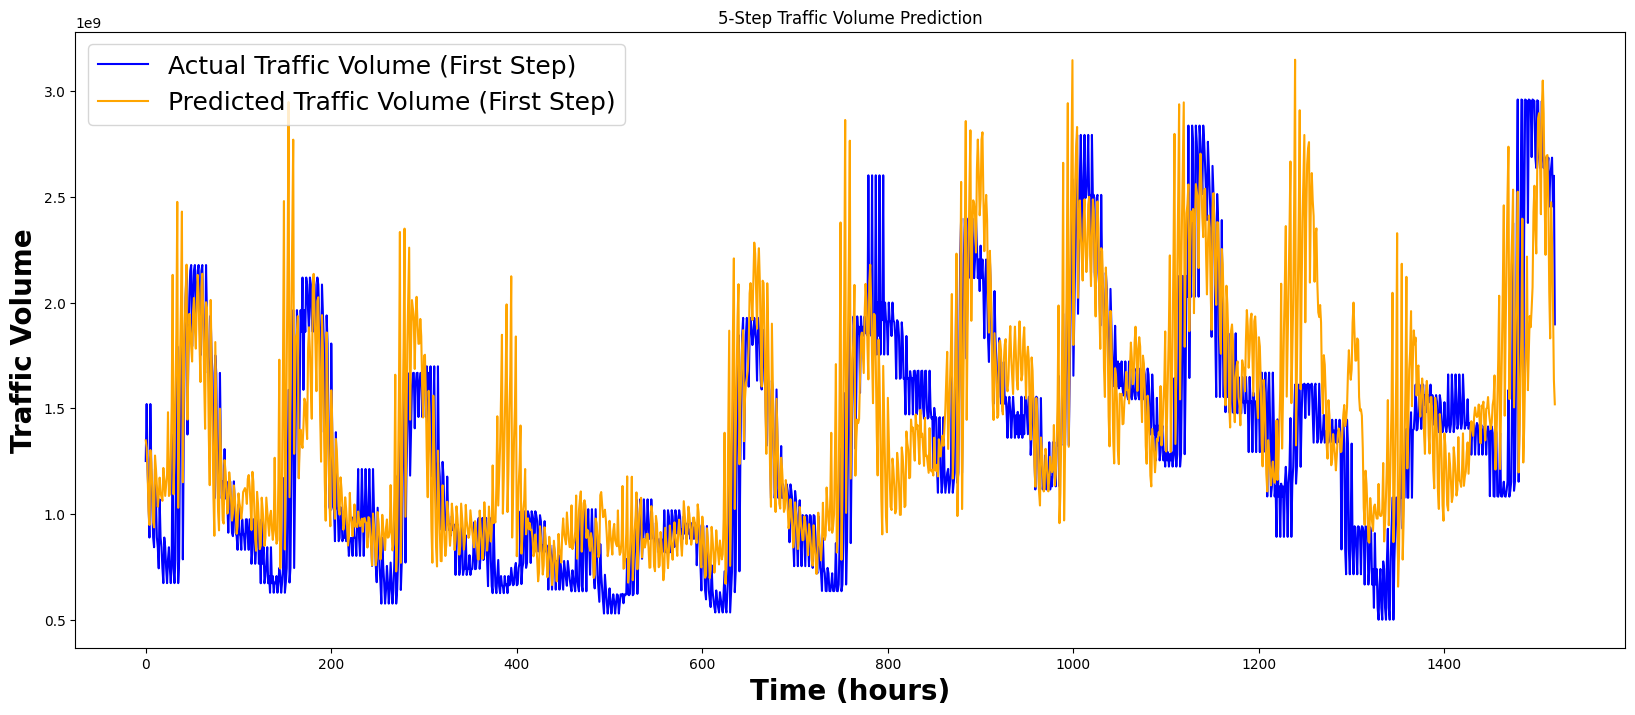

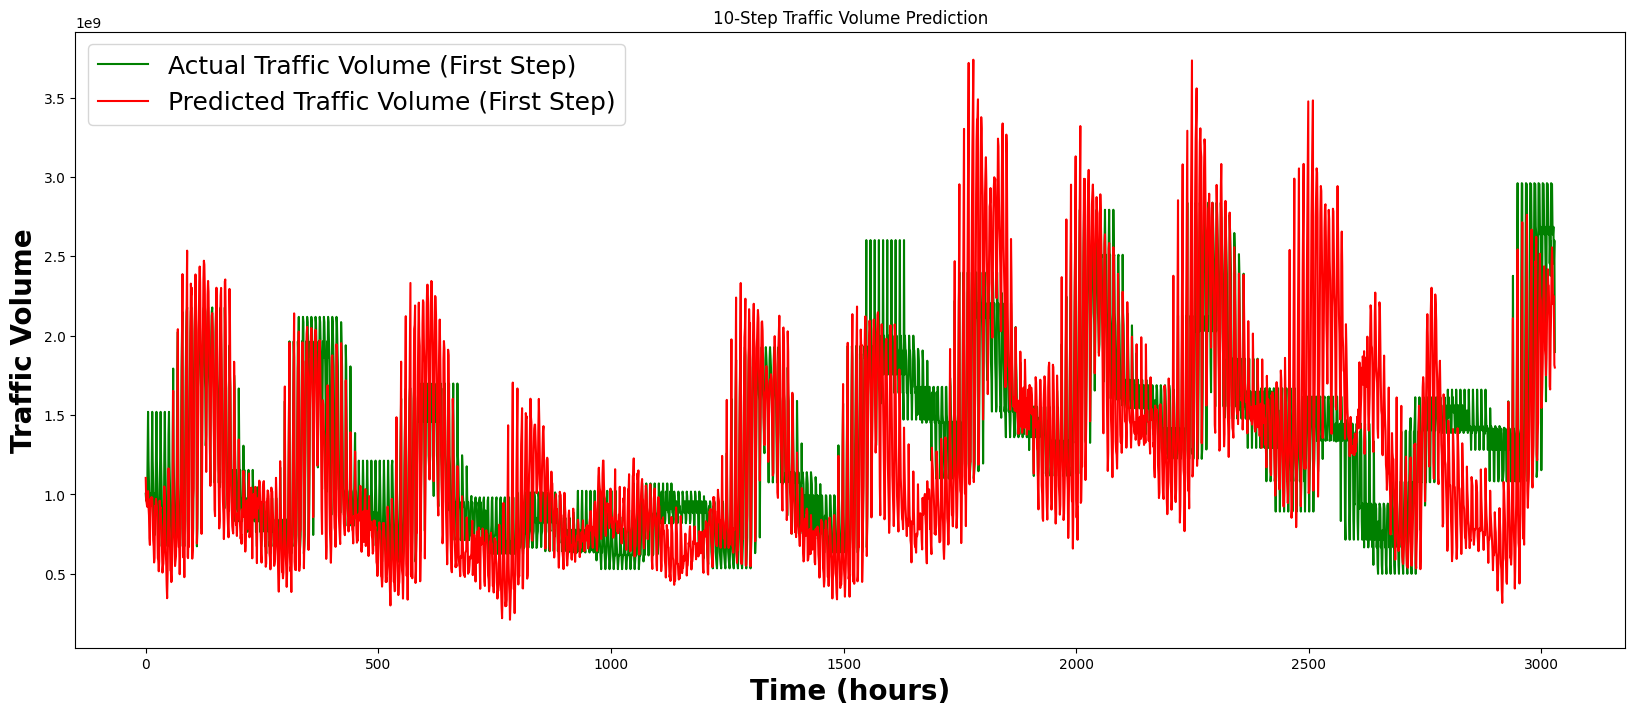

In [41]:

# Plot the 5-step prediction results
plt.figure(figsize=(20, 8))
plt.plot(y_test_rescaled_5[:, 0], label='Actual Traffic Volume (First Step)', color='blue')
plt.plot(predictions_rescaled_5[:, 0], label='Predicted Traffic Volume (First Step)', color='orange')
plt.xlabel('Time (hours)', fontsize=20, fontweight='bold')
plt.ylabel('Traffic Volume', fontsize=20, fontweight='bold')
plt.title('5-Step Traffic Volume Prediction')
plt.legend(fontsize=18)
plt.show()

# Plot the 10-step prediction results
plt.figure(figsize=(20, 8))
plt.plot(y_test_rescaled_10[:, 0], label='Actual Traffic Volume (First Step)', color='green')
plt.plot(predictions_rescaled_10[:, 0], label='Predicted Traffic Volume (First Step)', color='red')
plt.xlabel('Time (hours)', fontsize=20, fontweight='bold')
plt.ylabel('Traffic Volume', fontsize=20, fontweight='bold')
plt.title('10-Step Traffic Volume Prediction')
plt.legend(fontsize=18)
plt.show()


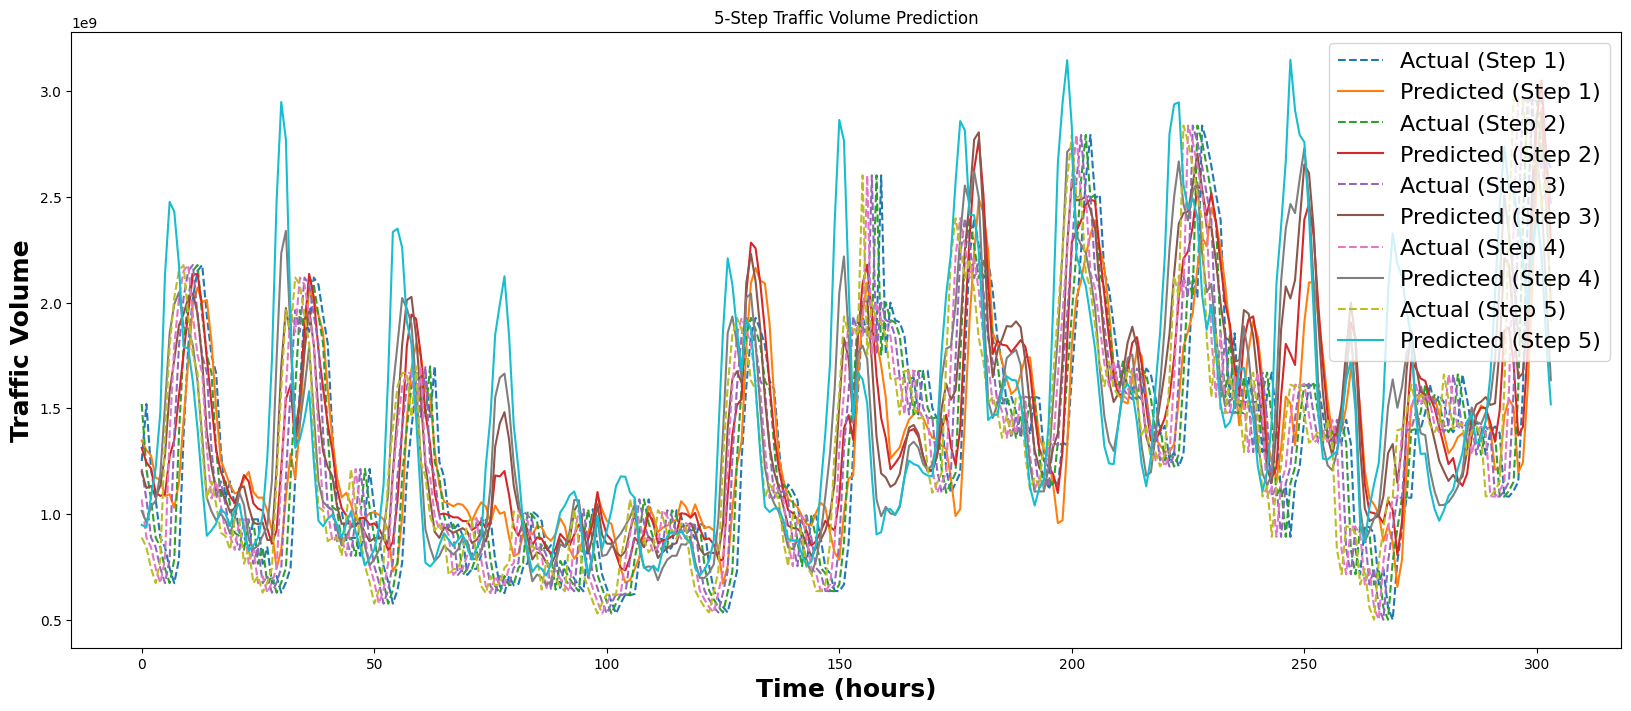

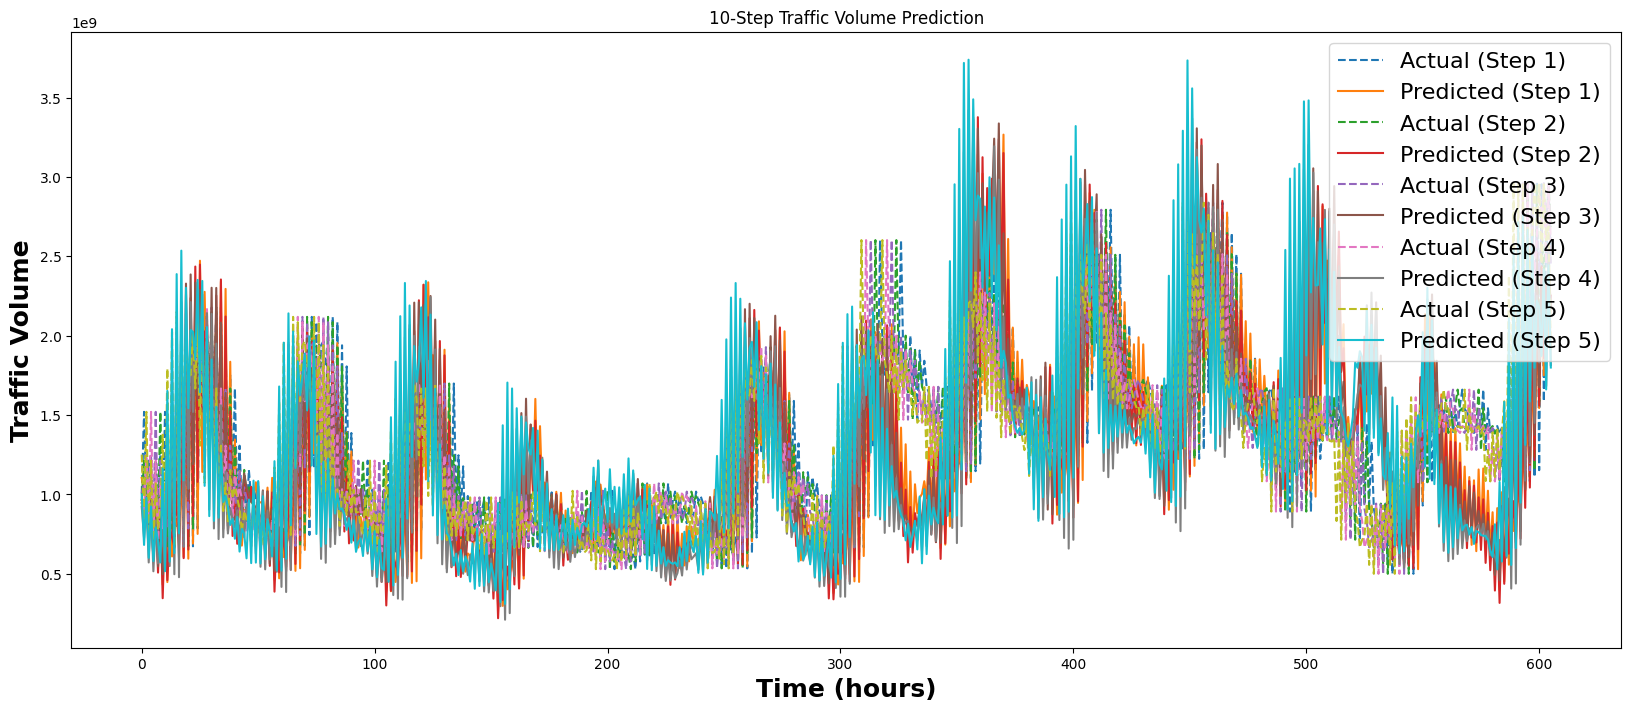

In [43]:
# Plot each step in the 5-step and 10-step predictions
plt.figure(figsize=(20, 8))
for step in range(n_steps_out):
    plt.plot(y_test_rescaled_5[:, step], label=f'Actual (Step {step+1})', linestyle='--')
    plt.plot(predictions_rescaled_5[:, step], label=f'Predicted (Step {step+1})', linestyle='-')
plt.xlabel('Time (hours)', fontsize=18, fontweight='bold')
plt.ylabel('Traffic Volume', fontsize=18, fontweight='bold')
plt.title('5-Step Traffic Volume Prediction')
plt.legend(fontsize=16)
plt.show()

plt.figure(figsize=(20, 8))
for step in range(n_steps_out):
    plt.plot(y_test_rescaled_10[:, step], label=f'Actual (Step {step+1})', linestyle='--')
    plt.plot(predictions_rescaled_10[:, step], label=f'Predicted (Step {step+1})', linestyle='-')
plt.xlabel('Time (hours)', fontsize=18, fontweight='bold')
plt.ylabel('Traffic Volume', fontsize=18, fontweight='bold')
plt.title('10-Step Traffic Volume Prediction')
plt.legend(fontsize=16)
plt.show()


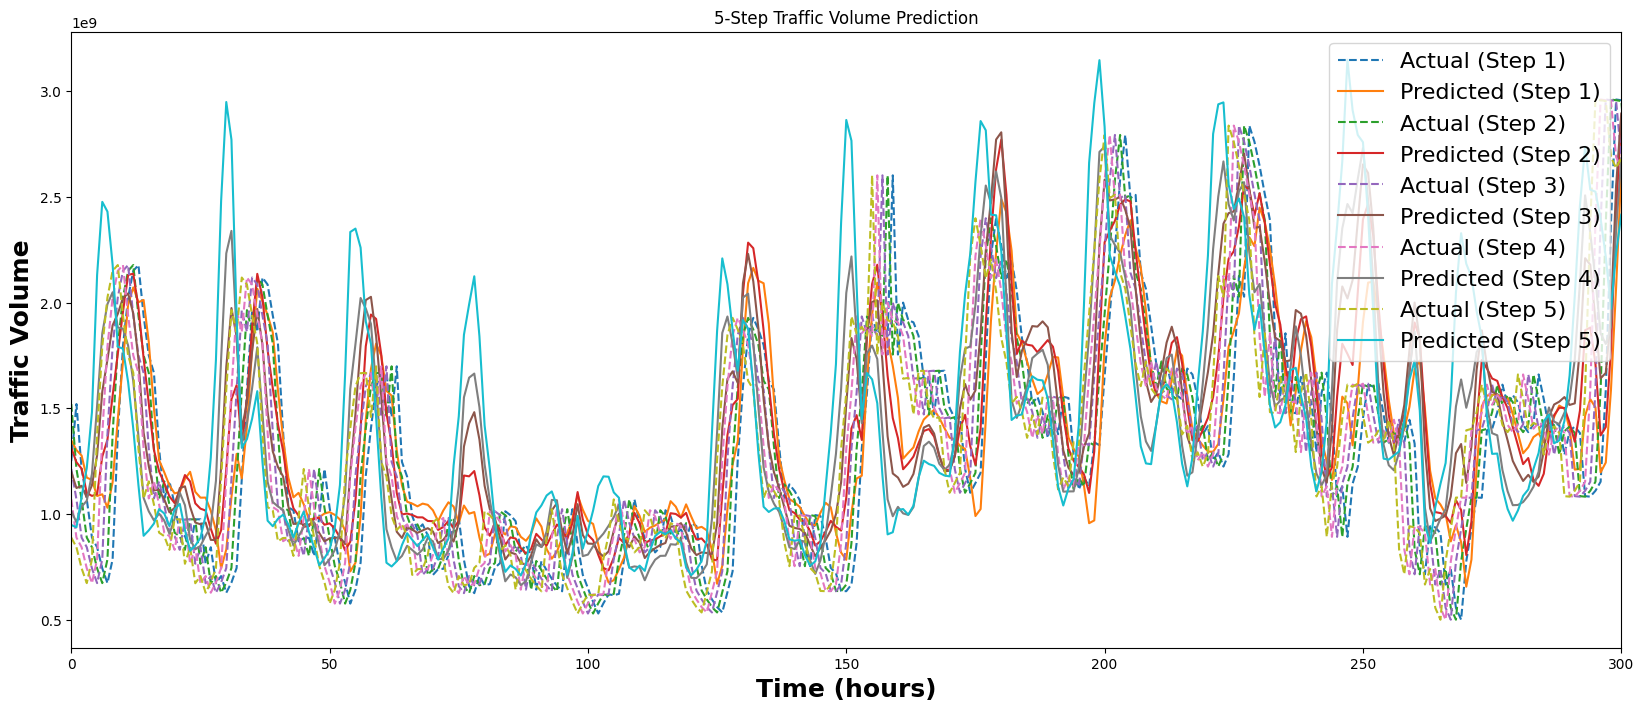

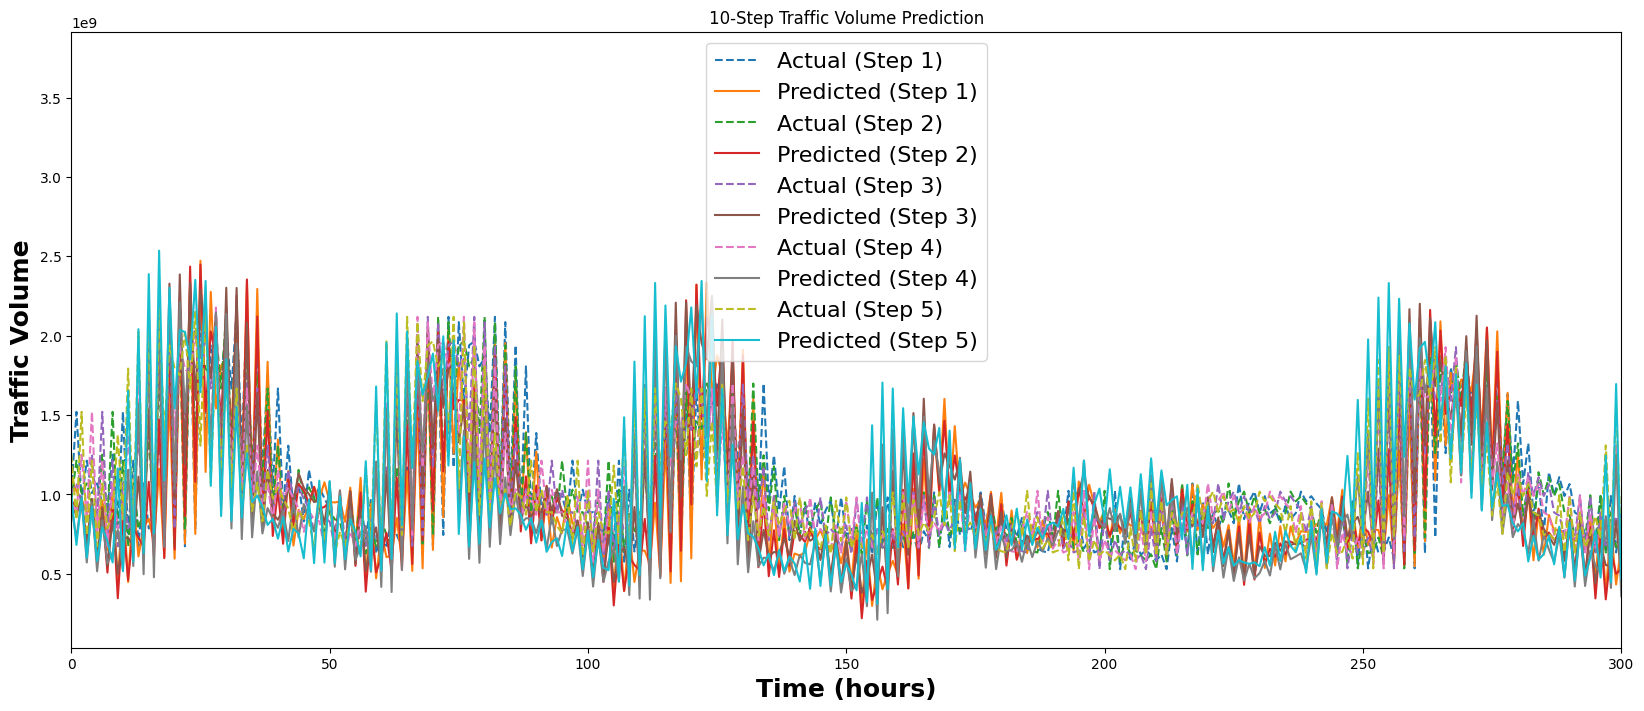

In [44]:
# Plot each step in the 5-step prediction
plt.figure(figsize=(20, 8))
for step in range(n_steps_out):
    plt.plot(y_test_rescaled_5[:, step], label=f'Actual (Step {step+1})', linestyle='--')
    plt.plot(predictions_rescaled_5[:, step], label=f'Predicted (Step {step+1})', linestyle='-')
plt.xlabel('Time (hours)', fontsize=18, fontweight='bold')
plt.ylabel('Traffic Volume', fontsize=18, fontweight='bold')
plt.title('5-Step Traffic Volume Prediction')
plt.xlim([0, 300])  # Limit the x-axis to show only up to 300 hours
plt.legend(fontsize=16)
plt.show()

# Plot each step in the 10-step prediction
plt.figure(figsize=(20, 8))
for step in range(n_steps_out):
    plt.plot(y_test_rescaled_10[:, step], label=f'Actual (Step {step+1})', linestyle='--')
    plt.plot(predictions_rescaled_10[:, step], label=f'Predicted (Step {step+1})', linestyle='-')
plt.xlabel('Time (hours)', fontsize=18, fontweight='bold')
plt.ylabel('Traffic Volume', fontsize=18, fontweight='bold')
plt.title('10-Step Traffic Volume Prediction')
plt.xlim([0, 300])  # Limit the x-axis to show only up to 300 hours
plt.legend(fontsize=16)
plt.show()


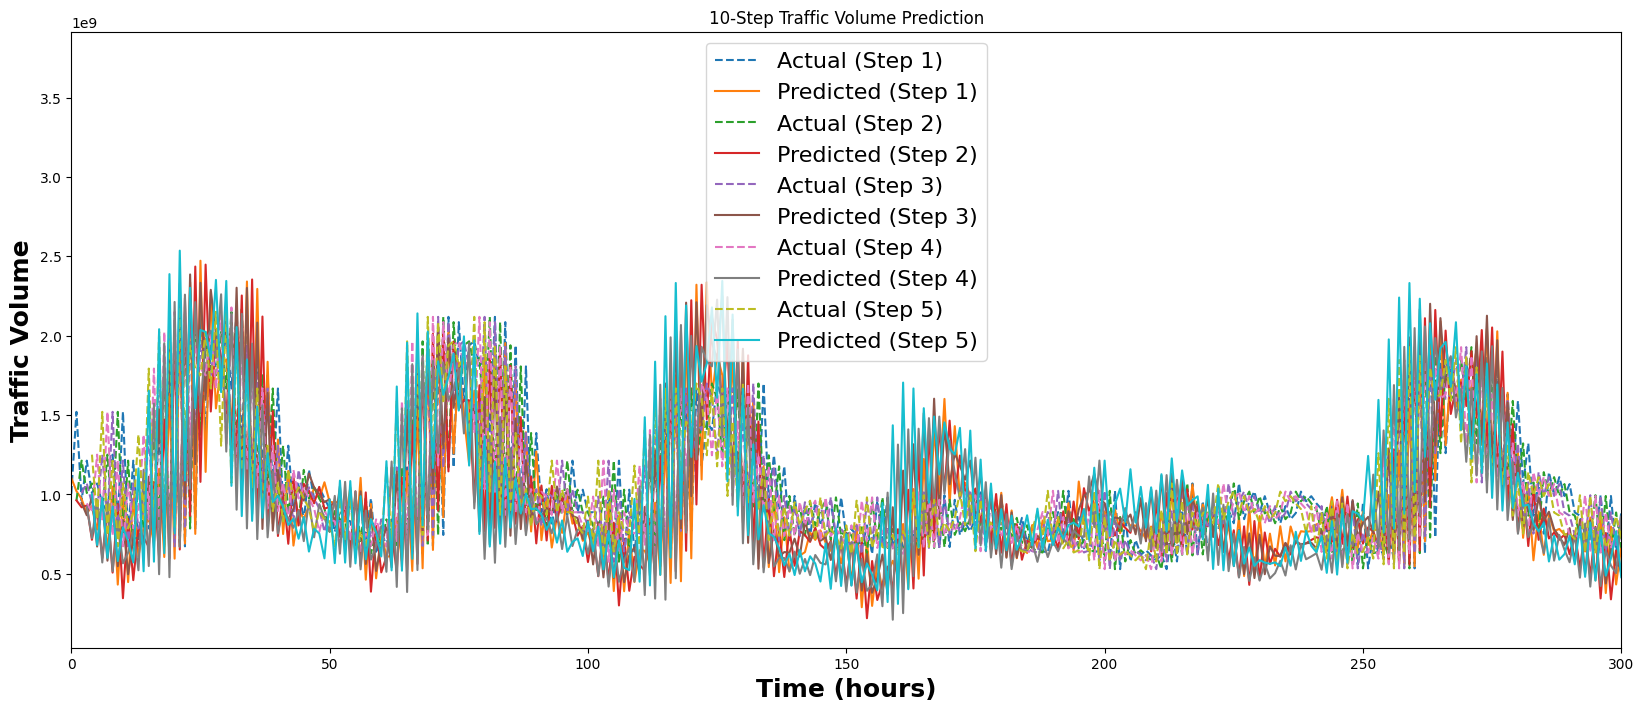

In [45]:
# Plot each step in the 10-step prediction
plt.figure(figsize=(20, 8))

for step in range(n_steps_out):
    # Plot actual values for each step with unique color and linestyle
    plt.plot(
        range(step, len(y_test_rescaled_10[:, step]) + step), 
        y_test_rescaled_10[:, step], 
        label=f'Actual (Step {step + 1})', 
        linestyle='--'
    )
    
    # Plot predicted values for each step with unique color and linestyle
    plt.plot(
        range(step, len(predictions_rescaled_10[:, step]) + step), 
        predictions_rescaled_10[:, step], 
        label=f'Predicted (Step {step + 1})', 
        linestyle='-'
    )

plt.xlabel('Time (hours)', fontsize=18, fontweight='bold')
plt.ylabel('Traffic Volume', fontsize=18, fontweight='bold')
plt.title('10-Step Traffic Volume Prediction')
plt.xlim([0, 300])  # Limit the x-axis to show only up to 300 hours
plt.legend(fontsize=16)
plt.show()


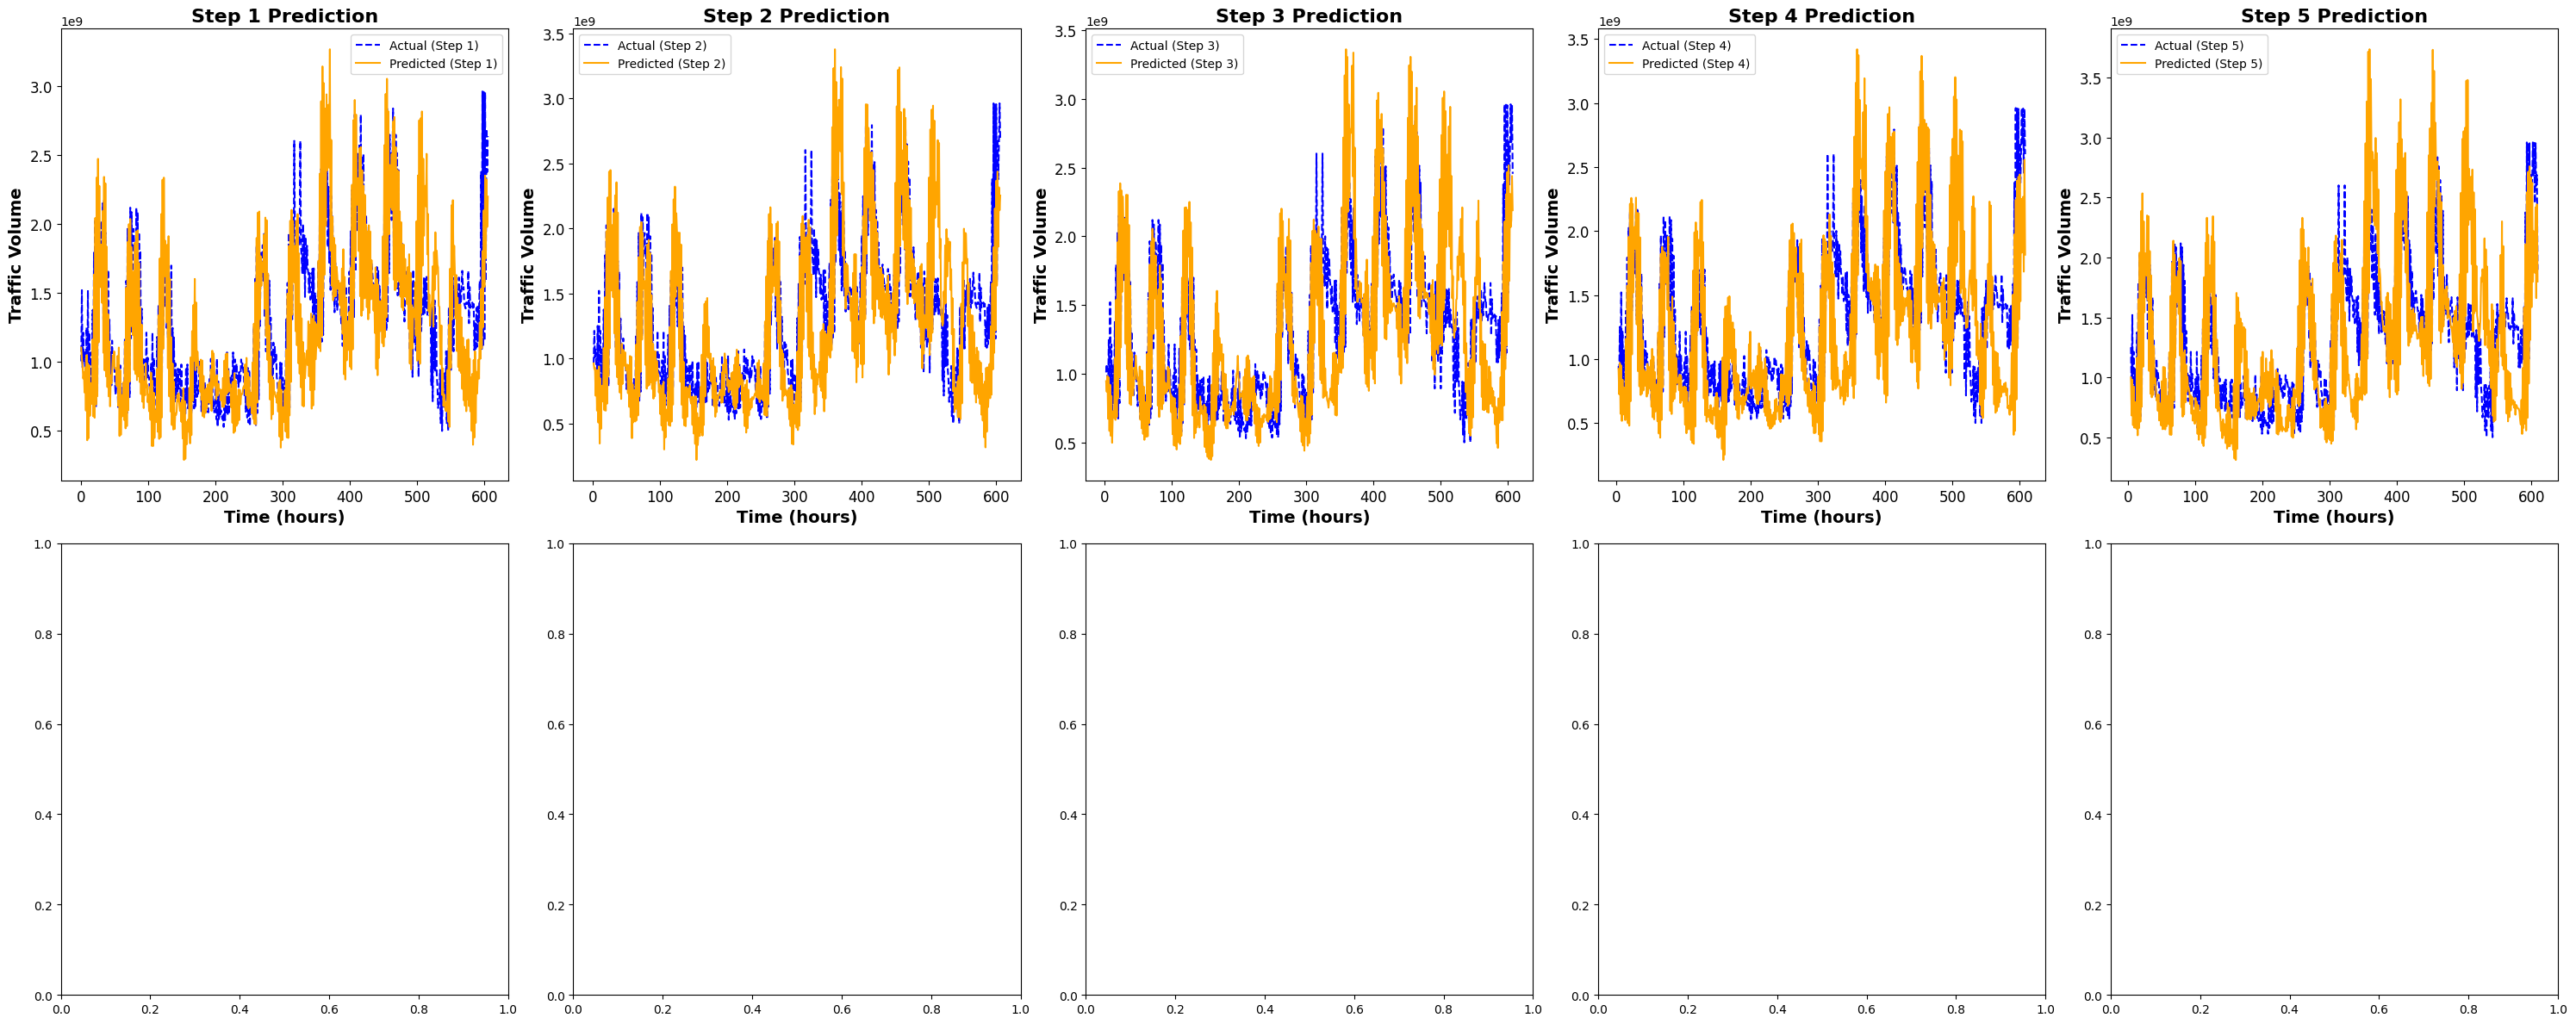

In [47]:
import matplotlib.pyplot as plt

# Create a figure with 10 subplots (2 rows, 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(30, 12))
axes = axes.ravel()  # Flatten the 2D array of axes for easier iteration

# Define colors for actual and predicted curves
actual_color = 'b'
predicted_color = 'orange'

# Plot each step in its own subplot
for step in range(n_steps_out):
    ax = axes[step]
    
    # Plot actual values for each step
    ax.plot(
        range(step, len(y_test_rescaled_10[:, step]) + step), 
        y_test_rescaled_10[:, step], 
        label=f'Actual (Step {step + 1})', 
        color=actual_color, 
        linestyle='--'
    )
    
    # Plot predicted values for each step
    ax.plot(
        range(step, len(predictions_rescaled_10[:, step]) + step), 
        predictions_rescaled_10[:, step], 
        label=f'Predicted (Step {step + 1})', 
        color=predicted_color, 
        linestyle='-'
    )
    
    ax.set_title(f'Step {step + 1} Prediction', fontsize=16, fontweight='bold')
    ax.set_xlabel('Time (hours)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Traffic Volume', fontsize=14, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=10)

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the combined figure with 10 subplots
plt.show()


In [48]:
print("Shape of y_test_rescaled_10:", y_test_rescaled_10.shape)
print("Shape of predictions_rescaled_10:", predictions_rescaled_10.shape)


Shape of y_test_rescaled_10: (606, 5)
Shape of predictions_rescaled_10: (606, 5)


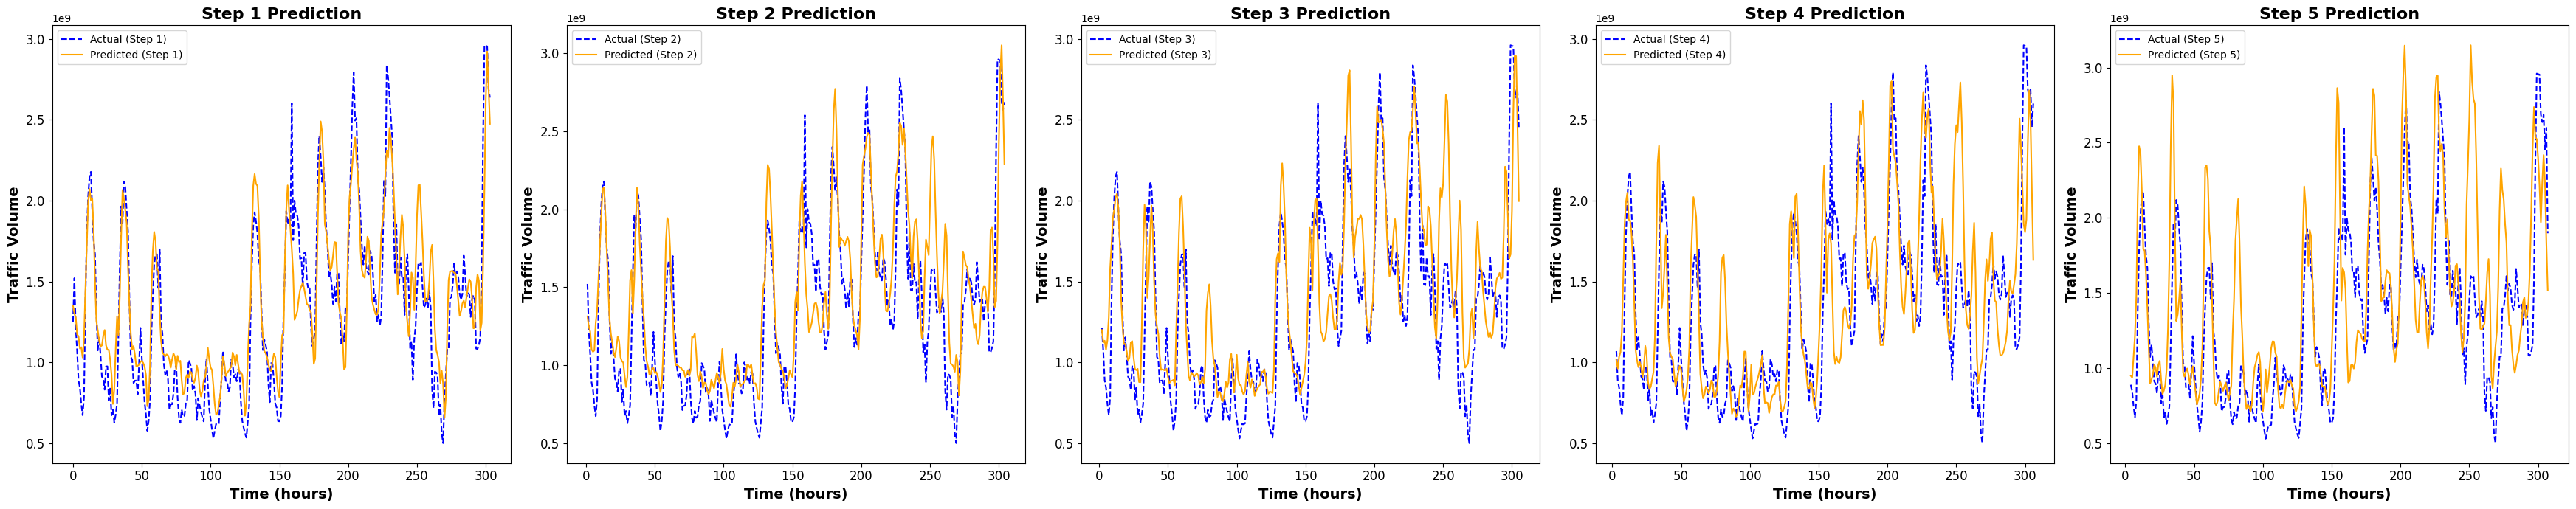

Shape of y_test_rescaled_5: (304, 5)
Shape of predictions_rescaled_5: (304, 5)


In [49]:
# %%
import matplotlib.pyplot as plt

# Create a figure with 5 subplots (1 row, 5 columns)
fig, axes = plt.subplots(1, 5, figsize=(35, 7))
axes = axes.ravel()  # Flatten the 2D array of axes for easier iteration

# Define colors for actual and predicted curves
actual_color = 'blue'
predicted_color = 'orange'

# Plot each step in its own subplot
for step in range(5):  # Adjust this for 5-step prediction
    ax = axes[step]
    
    # Plot actual values for each step
    ax.plot(
        range(step, len(y_test_rescaled_5[:, step]) + step), 
        y_test_rescaled_5[:, step], 
        label=f'Actual (Step {step + 1})', 
        color=actual_color, 
        linestyle='--'
    )
    
    # Plot predicted values for each step
    ax.plot(
        range(step, len(predictions_rescaled_5[:, step]) + step), 
        predictions_rescaled_5[:, step], 
        label=f'Predicted (Step {step + 1})', 
        color=predicted_color, 
        linestyle='-'
    )
    
    ax.set_title(f'Step {step + 1} Prediction', fontsize=16, fontweight='bold')
    ax.set_xlabel('Time (hours)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Traffic Volume', fontsize=14, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=10)

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the combined figure with 5 subplots
plt.show()

# %%
print("Shape of y_test_rescaled_5:", y_test_rescaled_5.shape)
print("Shape of predictions_rescaled_5:", predictions_rescaled_5.shape)


Epoch 1/200


/Users/maushariff/Downloads/Local_Disk_E/Byrav/Fall24 996 Reserach with Internet2 Data/VsCodeWorkspace/myenv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0247 - mae: 0.0953 - mse: 0.0247 - val_loss: 0.0035 - val_mae: 0.0426 - val_mse: 0.0035
Epoch 2/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0130 - mae: 0.0690 - mse: 0.0130 - val_loss: 0.0026 - val_mae: 0.0377 - val_mse: 0.0026
Epoch 3/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0128 - mae: 0.0701 - mse: 0.0128 - val_loss: 0.0032 - val_mae: 0.0429 - val_mse: 0.0032
Epoch 4/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0102 - mae: 0.0630 - mse: 0.0102 - val_loss: 0.0026 - val_mae: 0.0408 - val_mse: 0.0026
Epoch 5/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0105 - mae: 0.0633 - mse: 0.0105 - val_loss: 0.0050 - val_mae: 0.0510 - val_mse: 0.0050
Epoch 6/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0103 - mae: 0.0622 - mse: 0.0103 - val_loss: 0.0028 - val_mae: 0.0414 - val_mse: 0.0028
Epoch 7/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0102 - mae: 0.0636 - mse: 0.0102 - v

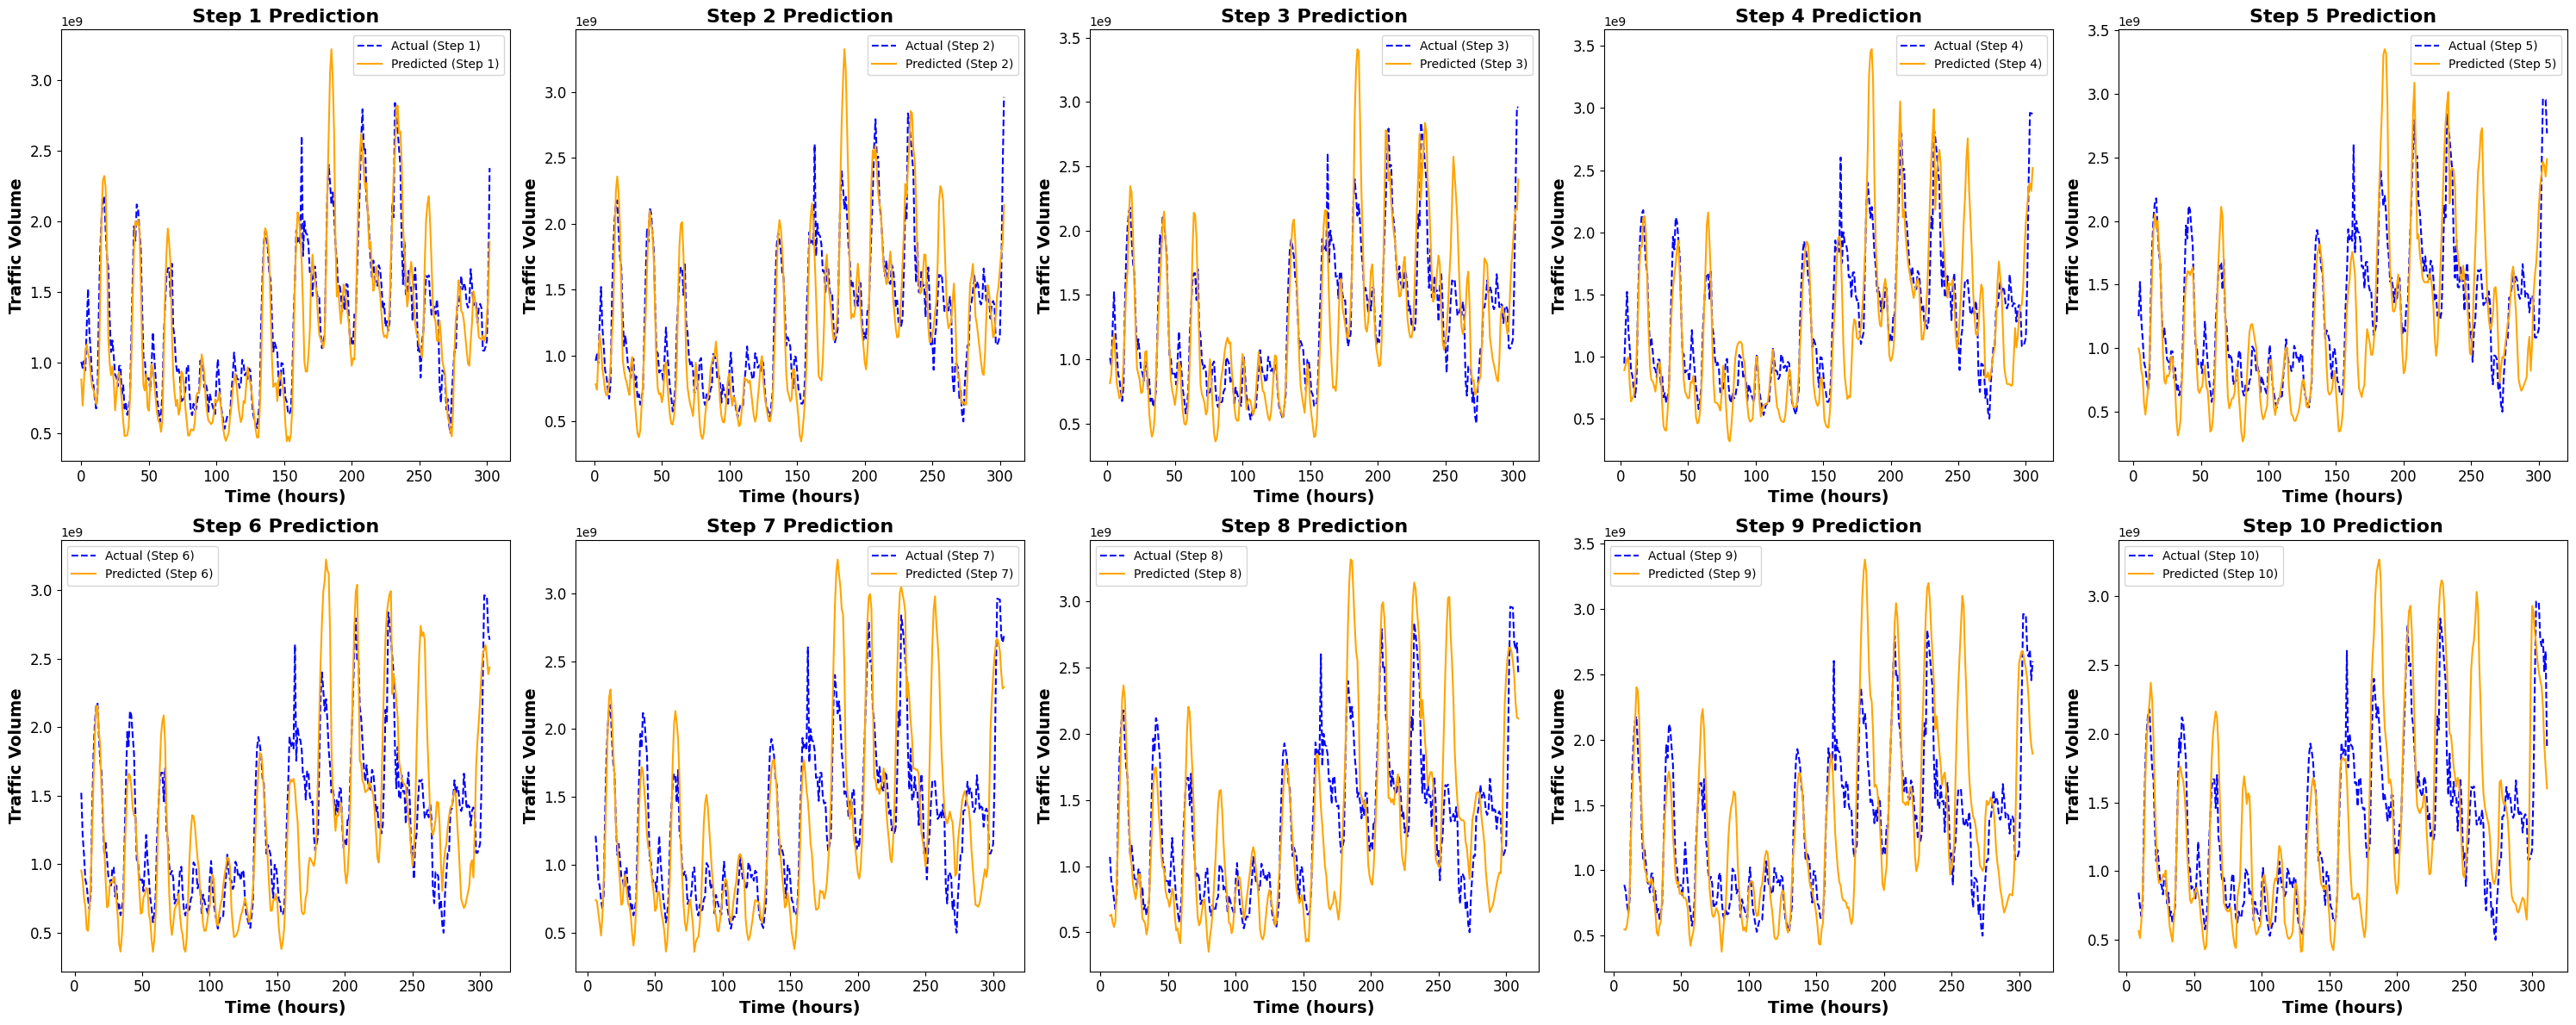

Shape of y_test_rescaled_10: (303, 10)
Shape of predictions_rescaled_10: (303, 10)


In [50]:
# %%
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import GRU, LSTM, Dropout, Dense
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Modify the function to create sequences for multi-step forecasting
def create_sequences(data, seq_length, n_steps_out):
    xs, ys = [], []
    for i in range(len(data) - seq_length - n_steps_out + 1):
        x = data[i:i + seq_length]
        y = data[i + seq_length:i + seq_length + n_steps_out]  # Predict multiple steps ahead
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Update sequence length and prediction steps
sequence_length = 24  # Using 24 previous hours as input
n_steps_out = 10  # For 10-step prediction

# Create sequences for 10-step forecasting
X, y = create_sequences(scaled_data, sequence_length, n_steps_out)

# Reshape X for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split data into training and testing sets
train_size = int(0.8 * X.shape[0])
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define and compile the LSTM-GRU model
def build_model(input_shape, n_steps_out):
    model = Sequential()
    model.add(GRU(64, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.25))
    model.add(LSTM(256))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(n_steps_out))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
    return model

# Train for 10-step prediction
model_10 = build_model((X_train.shape[1], X_train.shape[2]), n_steps_out)
model_10.fit(X_train, y_train, epochs=200, batch_size=8, verbose=1, validation_data=(X_test, y_test))

# %%
# Make predictions
predictions = model_10.predict(X_test)

# Reshape predictions and actual test data to match the inverse transformation requirements
predictions_reshaped = predictions.reshape(-1, 1)
y_test_reshaped = y_test.reshape(-1, 1)

# Inverse transform the predictions and actual data
predictions_rescaled_10 = scaler.inverse_transform(predictions_reshaped).reshape(-1, n_steps_out)
y_test_rescaled_10 = scaler.inverse_transform(y_test_reshaped).reshape(-1, n_steps_out)

# %%
import matplotlib.pyplot as plt

# Create a figure with 10 subplots (2 rows, 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(30, 12))
axes = axes.ravel()  # Flatten the 2D array of axes for easier iteration

# Define colors for actual and predicted curves
actual_color = 'b'
predicted_color = 'orange'

# Plot each step in its own subplot
for step in range(n_steps_out):
    ax = axes[step]
    
    # Plot actual values for each step
    ax.plot(
        range(step, len(y_test_rescaled_10[:, step]) + step), 
        y_test_rescaled_10[:, step], 
        label=f'Actual (Step {step + 1})', 
        color=actual_color, 
        linestyle='--'
    )
    
    # Plot predicted values for each step
    ax.plot(
        range(step, len(predictions_rescaled_10[:, step]) + step), 
        predictions_rescaled_10[:, step], 
        label=f'Predicted (Step {step + 1})', 
        color=predicted_color, 
        linestyle='-'
    )
    
    ax.set_title(f'Step {step + 1} Prediction', fontsize=16, fontweight='bold')
    ax.set_xlabel('Time (hours)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Traffic Volume', fontsize=14, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=10)

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the combined figure with 10 subplots
plt.show()

# %%
print("Shape of y_test_rescaled_10:", y_test_rescaled_10.shape)
print("Shape of predictions_rescaled_10:", predictions_rescaled_10.shape)


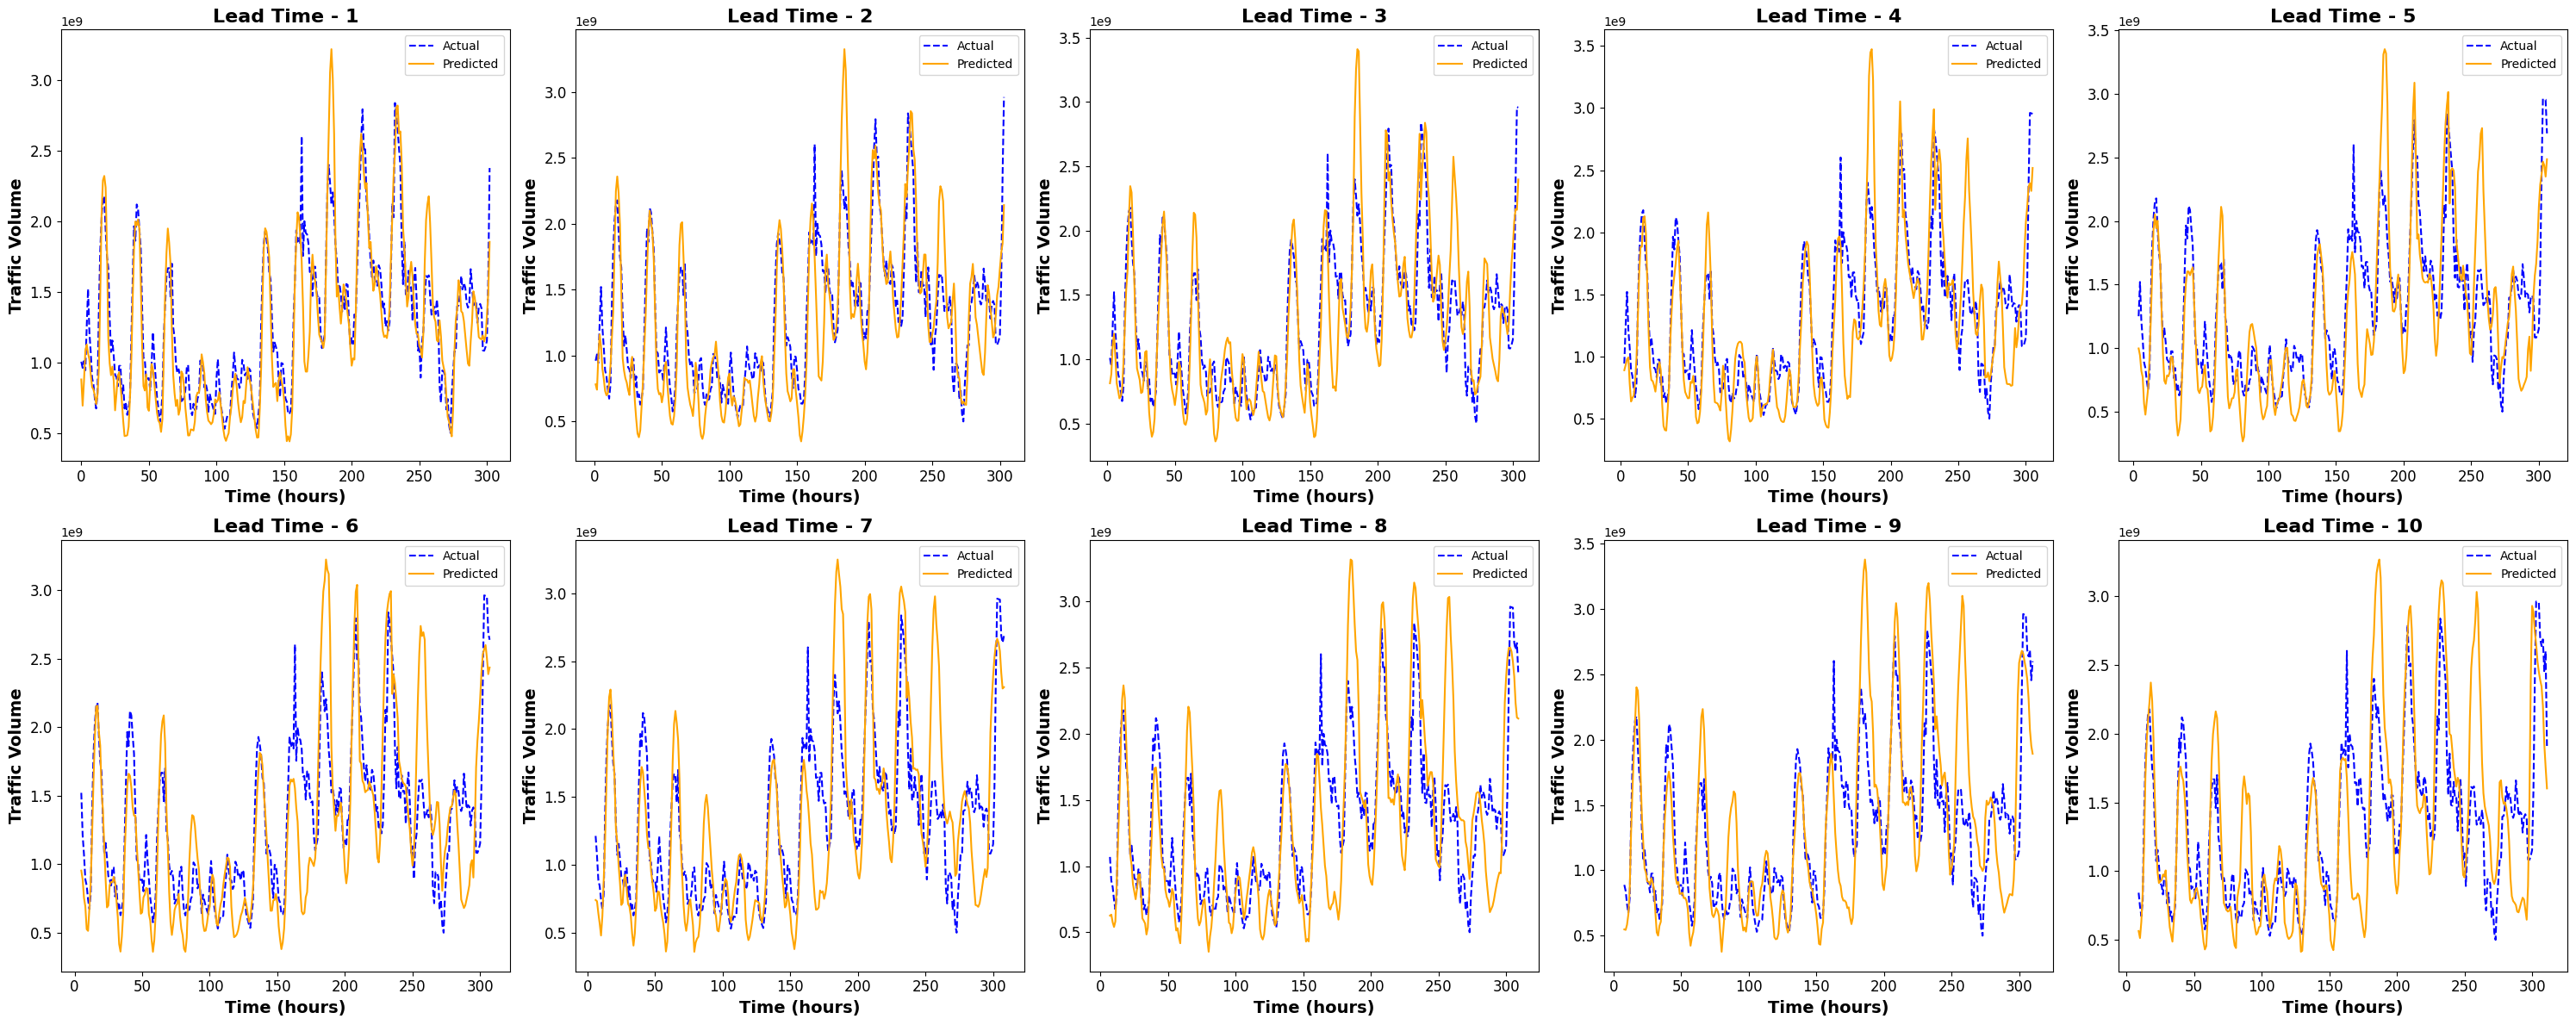

In [53]:
# %%
import matplotlib.pyplot as plt

# Create a figure with 10 subplots (2 rows, 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(30, 12))
axes = axes.ravel()  # Flatten the 2D array of axes for easier iteration

# Define colors for actual and predicted curves
actual_color = 'b'
predicted_color = 'orange'

# Plot each step in its own subplot
for step in range(n_steps_out):
    ax = axes[step]
    
    # Plot actual values for each step
    ax.plot(
        range(step, len(y_test_rescaled_10[:, step]) + step), 
        y_test_rescaled_10[:, step], 
        label=f'Actual', 
        color=actual_color, 
        linestyle='--'
    )
    
    # Plot predicted values for each step
    ax.plot(
        range(step, len(predictions_rescaled_10[:, step]) + step), 
        predictions_rescaled_10[:, step], 
        label=f'Predicted', 
        color=predicted_color, 
        linestyle='-'
    )
    
    ax.set_title(f'Lead Time - {step + 1}', fontsize=16, fontweight='bold')
    ax.set_xlabel('Time (hours)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Traffic Volume', fontsize=14, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=10)

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the combined figure with 10 subplots
plt.show()

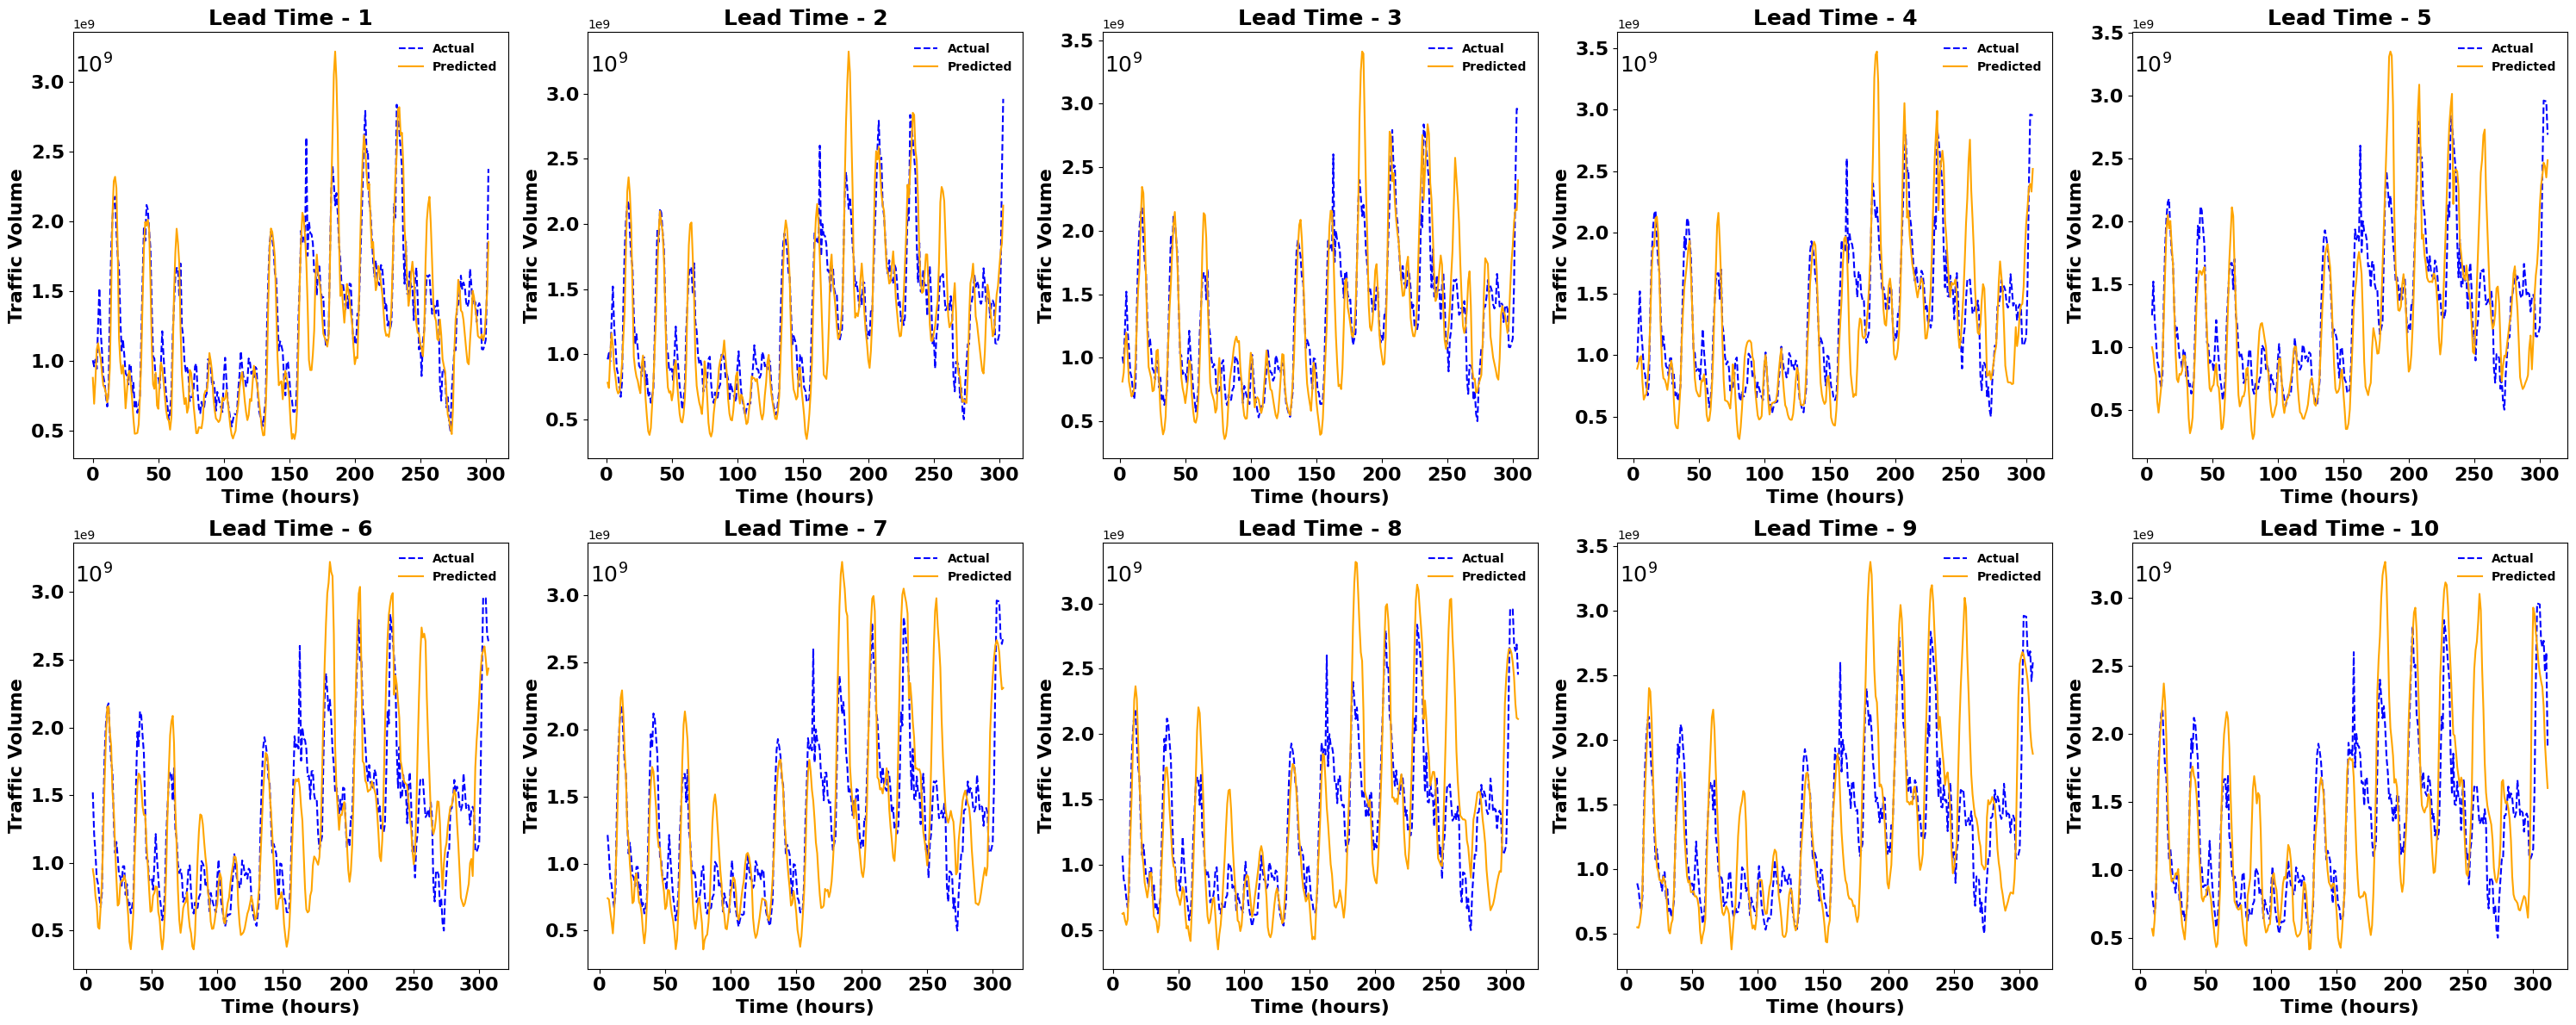

In [61]:
# %%
import matplotlib.pyplot as plt

# Create a figure with 10 subplots (2 rows, 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(30, 12))
axes = axes.ravel()  # Flatten the 2D array of axes for easier iteration

# Define colors for actual and predicted curves
actual_color = 'b'
predicted_color = 'orange'

# Plot each step in its own subplot
for step in range(n_steps_out):
    ax = axes[step]
    
    # Plot actual values for each step
    ax.plot(
        range(step, len(y_test_rescaled_10[:, step]) + step), 
        y_test_rescaled_10[:, step], 
        label=f'Actual', 
        color=actual_color, 
        linestyle='--'
    )
    
    # Plot predicted values for each step
    ax.plot(
        range(step, len(predictions_rescaled_10[:, step]) + step), 
        predictions_rescaled_10[:, step], 
        label=f'Predicted', 
        color=predicted_color, 
        linestyle='-'
    )
    
    ax.set_title(f'Lead Time - {step + 1}', fontsize=18, fontweight='bold')
    ax.set_xlabel('Time (hours)', fontsize=16, fontweight='bold')
    ax.set_ylabel('Traffic Volume', fontsize=16, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=16, labelcolor='black')
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
    ax.legend(fontsize=14, frameon=False, loc='upper right', prop={'weight': 'bold'})

    ax.annotate(r'$10^{9}$', xy=(0.005, 0.95), xycoords='axes fraction', fontsize=18,
                 verticalalignment='top', fontweight='bold')

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the combined figure with 10 subplots
plt.show()
